In [2]:
import pandas as pd
# from pandas.plotting import scatter_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
N_JOBS = 5

In [36]:
datatrain = pd.read_csv('dataset/fraud_train.csv')
datatest = pd.read_csv('dataset/fraud_train.csv')

# Step
1. praprocessing
    1. preparing the preparation
    2. Exploratory Data Analysis
    3. Dealing with Missing Values
    4. Dealing with Outliers
    5. Dealing with Imbalanced Data
    6. Data Transformations
    7. Finishing Touches & Moving Ahead
2. process
    1. Logistic Regression
    2. Decision Tree
    3. Random Forest
    4. Neural Networks
3. summary and conclutions

## Refference
1. praprocessing 
    1. https://www.kdnuggets.com/2017/06/7-steps-mastering-data-preparation-python.html/2
    1. https://github.com/pandas-profiling/pandas-profiling
    2. https://machinelearningmastery.com/prepare-data-machine-learning-python-scikit-learn/
    3. https://www.geeksforgeeks.org/data-preprocessing-machine-learning-python/
    1. https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/
1. process

## 1. Praprocessing

### B. Exploratory Data Analysis

In [37]:
datatrain.head()

,X,id_tanggal_transaksi_awal,tanggal_transaksi_awal,tipe_kartu,id_merchant,nama_merchant,tipe_mesin,tipe_transaksi,nama_transaksi,nilai_transaksi,...,nama_channel,id_channel,flag_transaksi_finansial,status_transaksi,bank_pemilik_kartu,rata_rata_nilai_transaksi,maksimum_nilai_transaksi,minimum_nilai_transaksi,rata_rata_jumlah_transaksi,flag_transaksi_fraud
0,4676,2457646,2457726,111,-2,1798,2605127,26,10,2200000.0,...,1,9,False,3,999,1.332293e+06,9750000.0,10000.0,2.73,0
1,788,2457419,2457507,111,-2,1798,-3,156,12,2500000.0,...,5,8,False,3,999,1.369048e+06,10000000.0,30000.0,2.33,1
2,1520,2457521,2457612,2,-2,1798,-3,156,12,1200000.0,...,5,8,False,3,999,1.552346e+07,100000000.0,41804.0,2.40,0
3,9346,2457659,2457746,103,75336,249,2806174,58,6,320000.0,...,2,4,False,3,999,7.117647e+05,6884408.0,10000.0,1.98,0
4,2914,2457311,2457385,0,-2,1798,2334932,26,10,150000.0,...,1,9,False,3,999,6.179683e+05,2500000.0,100000.0,1.46,0


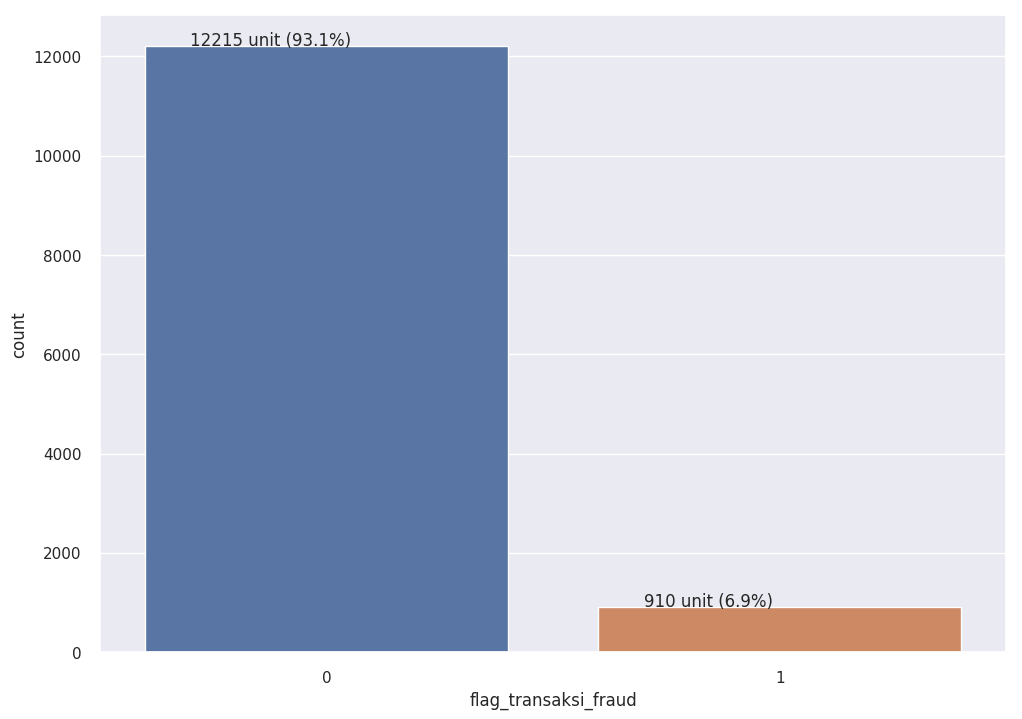

In [38]:
datatrain["flag_transaksi_fraud"].value_counts()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x="flag_transaksi_fraud", data=datatrain)

total = len(datatrain)
for p in ax.patches:
        ax.annotate('{} unit ({:.1f}%)'.format(p.get_height(), 100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

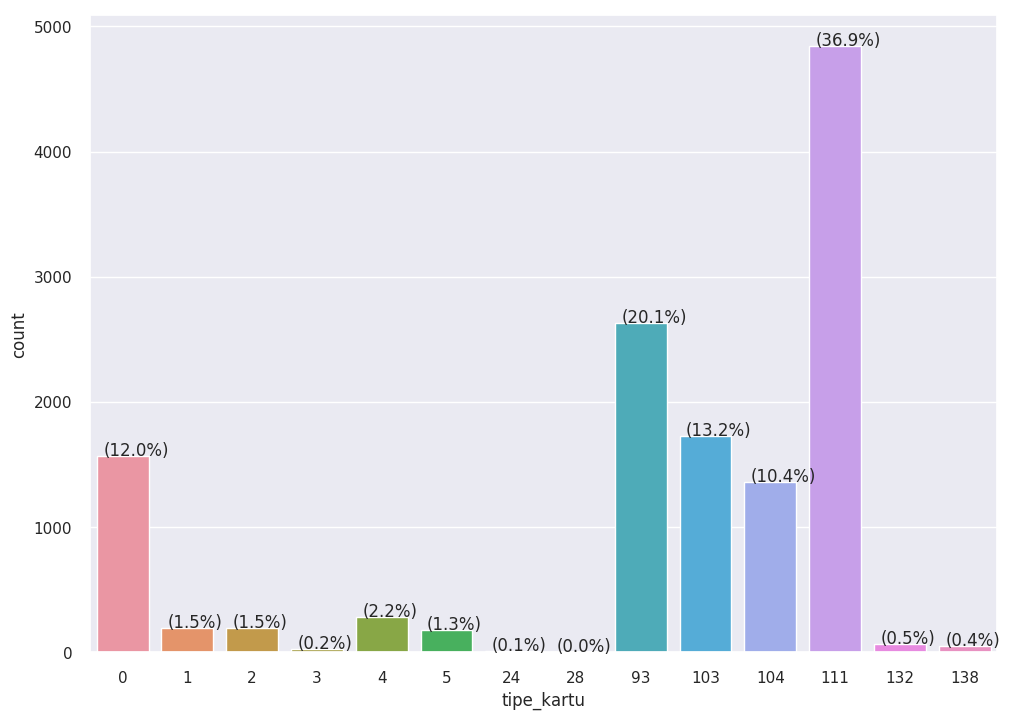

In [39]:
datatrain["tipe_kartu"].value_counts()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x="tipe_kartu", data=datatrain)

total = len(datatrain)
for p in ax.patches:
        ax.annotate('({:.1f}%)'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

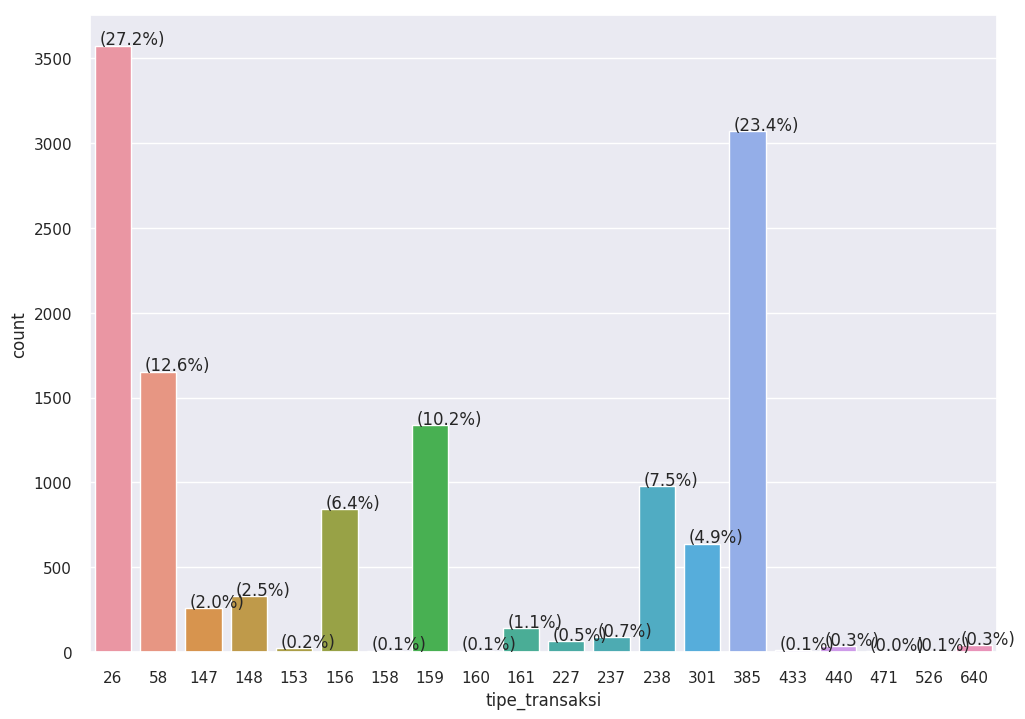

In [40]:
datatrain["tipe_transaksi"].value_counts()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x="tipe_transaksi", data=datatrain)

total = len(datatrain)
for p in ax.patches:
        ax.annotate('({:.1f}%)'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

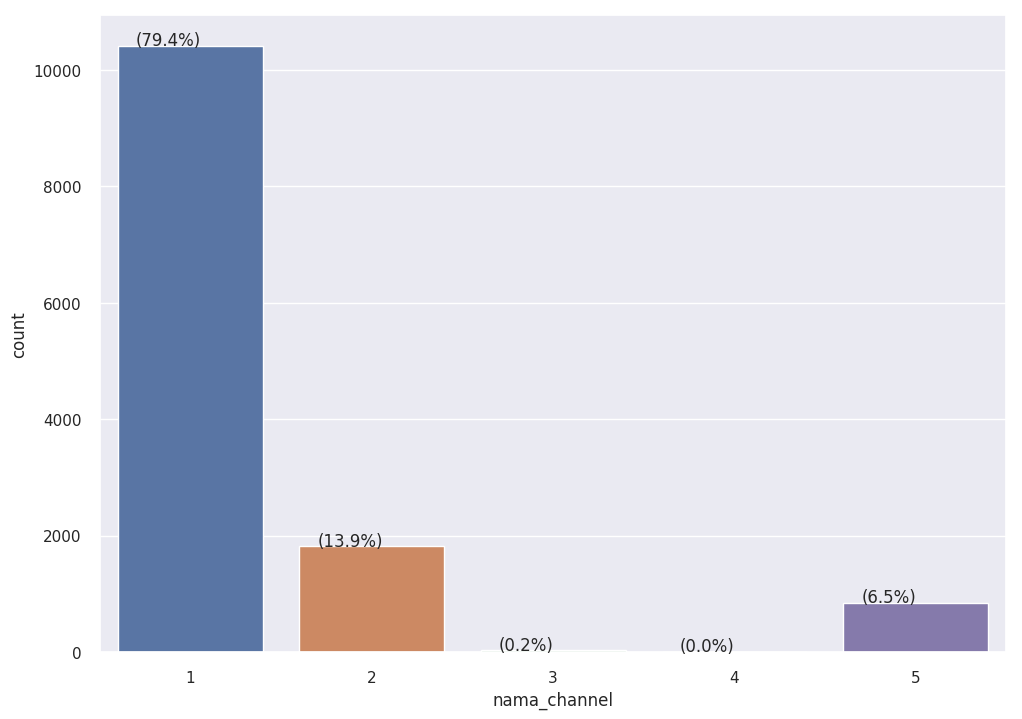

In [41]:
datatrain["nama_channel"].value_counts()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x="nama_channel", data=datatrain)

total = len(datatrain)
for p in ax.patches:
        ax.annotate('({:.1f}%)'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

In [55]:
# datatrain.corr()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcdcac84080>,
      dtype=object)

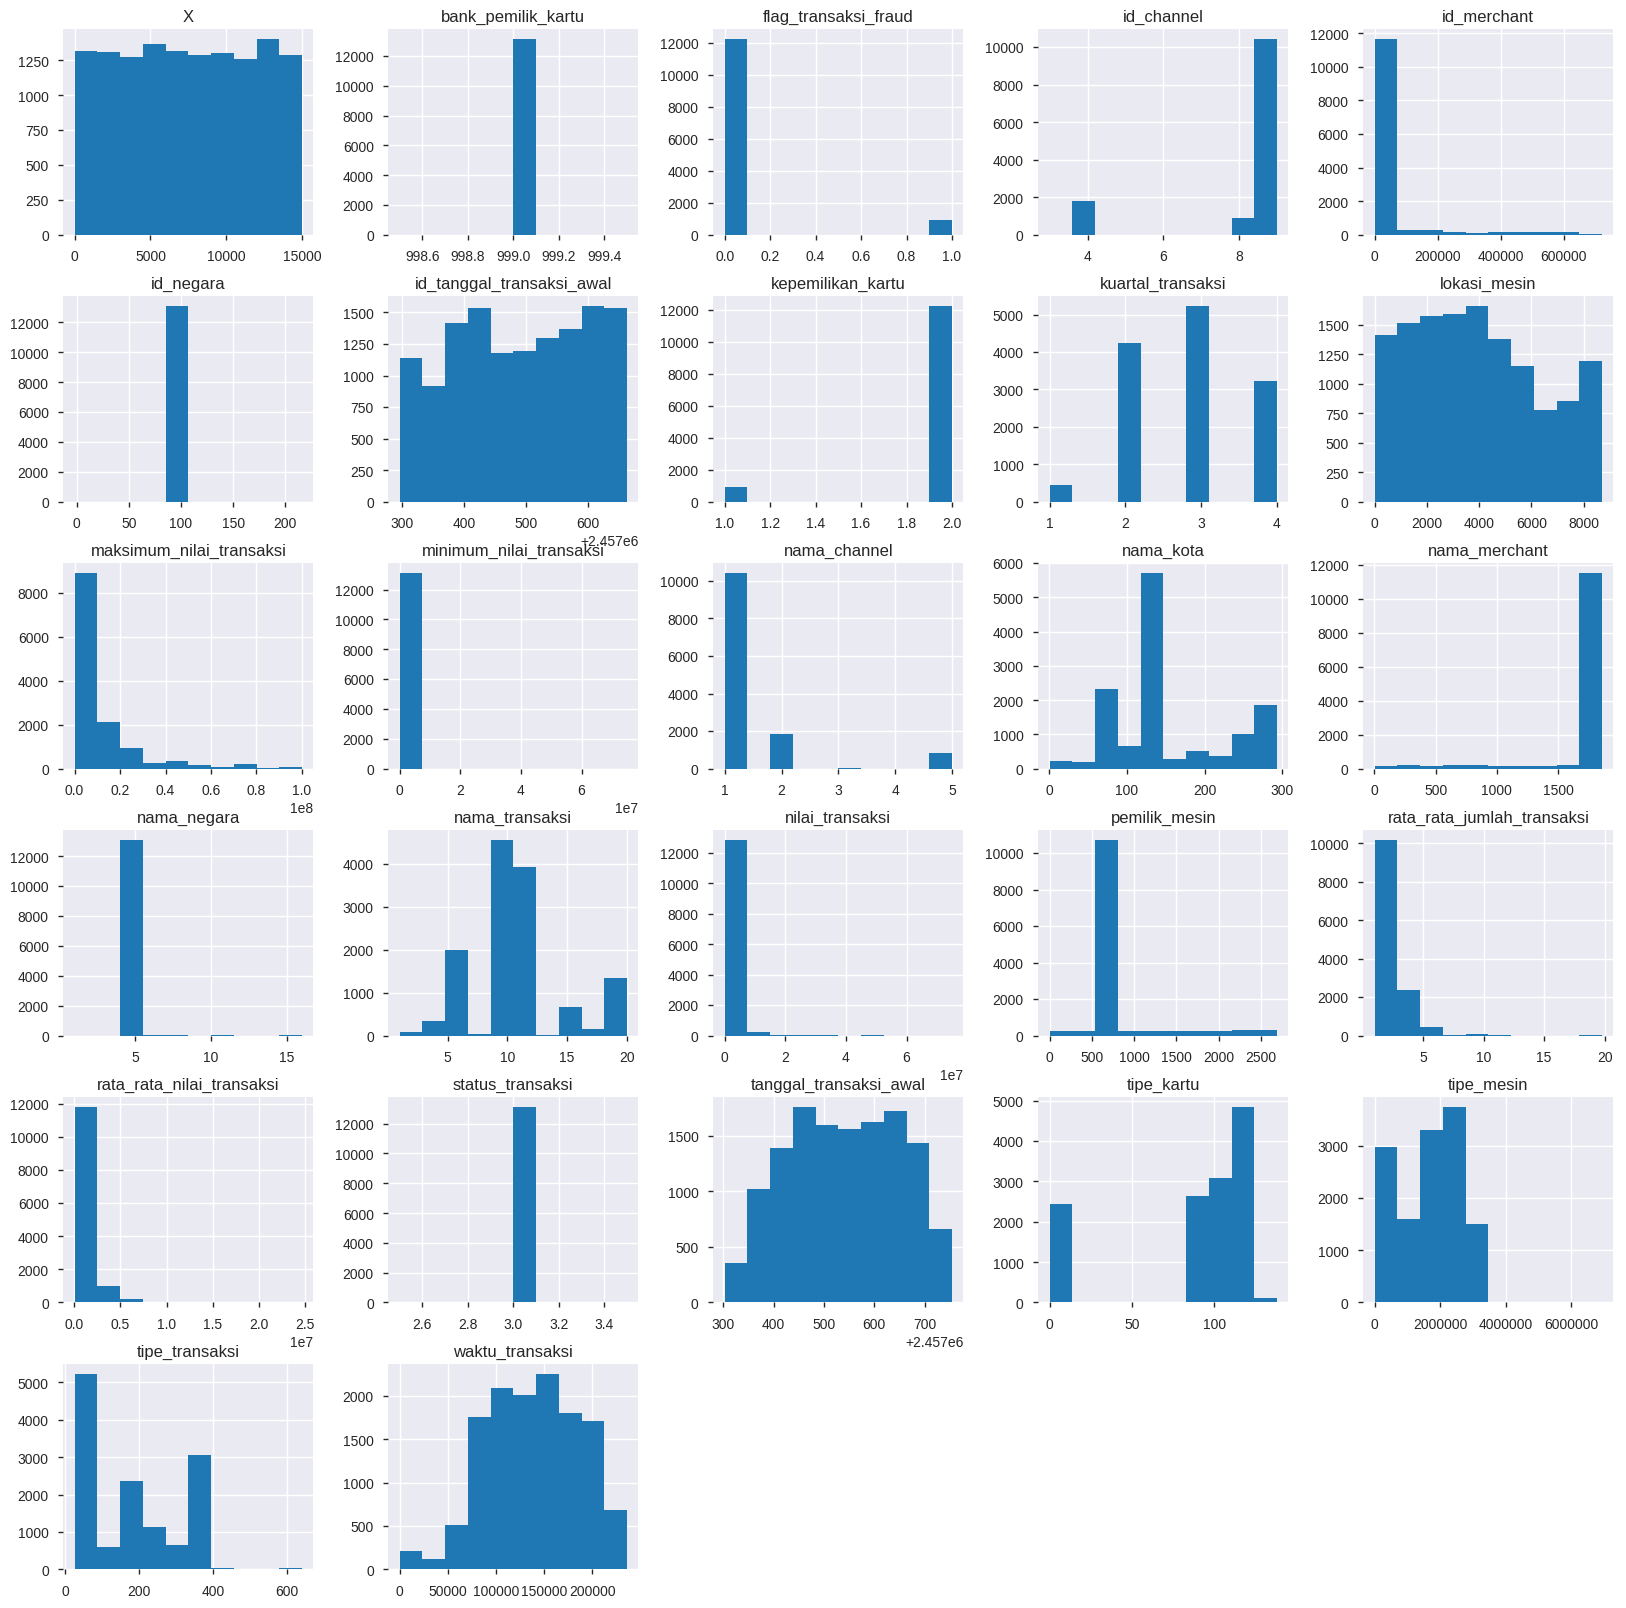

In [48]:
datatrain[datatrain.dtypes[(datatrain.dtypes=="float64")|(datatrain.dtypes=="int64")].index.values].hist(figsize=[20,20])

In [54]:
import pandas_profiling
pandas_profiling.ProfileReport(datatrain)

Number of variables,28
Number of observations,13125
Total Missing (%),0.0%
Total size in memory,2.7 MiB
Average record size in memory,217.0 B
Numeric,21
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,5


In [58]:
from gtts import gTTS
from io import BytesIO

mp3_fp = BytesIO()
tts = gTTS('halo apa kabar?', 'en')
tts.write_to_fp(mp3_fp)
